# ROBERTA MODEL

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from google.colab import drive
drive.mount('/content/drive')
LIBRARY_PATH = '/content/drive/MyDrive/NLP PROJECT/Finals/'

!pip install transformers
!pip install sentencepiece
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from transformers import AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader,RandomSampler, SequentialSampler
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from transformers import XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from keras.preprocessing.sequence import pad_sequences
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import os 
import seaborn as sns
import matplotlib.pyplot as plt 


Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 57.0 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 74.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.2 MB/s 


In [ ]:
# parameters 
batch_size = 8
epochs = 5
lr = 2e-5
clip_value = 1
epsilon = 1e-3
dropout = 0.4


In [ ]:
#  XLMRoberta class that takes paired document , encode them and pass them to a Regression Layer for classification 


class PairedXLMRobertaRegressor(nn.Module):
    def __init__(self,model= None,max_len = 512,drop_rate =dropout, freeze_roberta =False):
        super().__init__()
        D_in, D_out = 768, 1
        if model == None:
            self.model = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        else:
          self.model = model
        self.activation = nn.GELU()
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in,100),
            self.activation,
            nn.Dropout(drop_rate),
            nn.Linear(100, D_out))

    

    def forward(self,input_ids, attention_masks):
        outputs= self.model(input_ids, attention_masks)
        output = outputs[1]
        output = self.regressor(output)
        return output


class ModelHelper():
    def __init__(self,tokenizer_name = 'xlm-roberta-base',model_name='XLMRobertaRegressor',max_len =512):
      self.train_data = train_data
      self.test_data = test_data
      self.tokenizer =  AutoTokenizer.from_pretrained(tokenizer_name)
      self.max_len = max_len
      self.model_name = model_name

    def get_input_ids_labels(self):
      input_ids = []
      mask_ids = []
      for idx, row in self.train_data.iterrows():
            # print(idx)
            seed_text, target_text = row.text1_truncated + " " + " ".join(row.meta_keywords1) , row.text2_truncated + " " + " ".join(row.meta_keywords2)
            encode_dict = self.tokenizer(seed_text,target_text,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  add_special_tokens=True,
                                                          )
            input_ids.append(encode_dict['input_ids'])
            mask_ids.append(encode_dict['attention_mask'])
      labels = self.train_data.Overall.values
      labels = [float(x) for x in labels]
      return input_ids, mask_ids, labels

    def get_loaders(self,batch_size,input_ids,attention_masks,labels):
        train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                                    random_state=2022, test_size=0.1)
        
        train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                                     random_state=2022, test_size=0.1)
        
        train_inputs = torch.tensor(train_inputs)
        validation_inputs = torch.tensor(validation_inputs)

        train_labels = torch.tensor(train_labels)
        validation_labels = torch.tensor(validation_labels)

        train_masks = torch.tensor(train_masks)
        validation_masks = torch.tensor(validation_masks)

        # Create the DataLoader for our training set.
        train_data = TensorDataset(train_inputs, train_masks, train_labels)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

        # Create the DataLoader for our validation set.
        validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

        return train_dataloader, validation_dataloader

    
    def AdamOptimizer(self, learning_rate, epsilon):
        optimizer = torch.optim.AdamW(model.parameters(),lr= learning_rate, weight_decay = epsilon)
        return optimizer
    

    def get_scheduler(self, epochs, optimizer, train_dataloader):

        # Total number of training steps is number of batches * number of epochs.
        total_steps = len(train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
        return scheduler
   
    def save_model(self,model):

        # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

        output_dir = '/content/drive/MyDrive/NLP PROJECT/Finals/Model/'+ self.model_name +'.pth'

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration 
        torch.save(model.state_dict(), output_dir)
    
        
    

    def model_loss(self, loss_values,val_values):

        # Use plot styling from seaborn.
        sns.set(style='darkgrid')

        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)

        # Plot the learning curve.
        plt.plot(loss_values, 'b-o',label='Training')
        plt.plot(val_values, 'g-o',label="validation")

        # Label the plot.
        plt.title("Training loss and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")

        plt.xticks([i + 1 for i in range(epochs)])

        plt.show()
    
    def model_score(self,train_scores,val_scores):
        # Use plot styling from seaborn.
        sns.set(style='darkgrid')

        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)

        # Plot the learning curve.
        plt.plot(train_scores, 'b-o',label='Training')
        plt.plot(val_scores, 'g-o',label="validation")

        # Label the plot.
        plt.title("Training loss and Validation  Pearson correlation")
        plt.xlabel("Epoch")
        plt.ylabel("Pearson Correlation")
        plt.xticks([i + 1 for i in range(epochs)])
        plt.show()


    def prepare_text_for_eval(self,batch_size = batch_size):
        input_ids = []
        mask_ids = []
        for idx, row in self.test_data.iterrows():
            seed_text, target_text = row.text1_truncated + " " + " ".join(row.meta_keywords1) , row.text2_truncated + " " + " ".join(row.meta_keywords2)
            encode_dict = self.tokenizer(seed_text,target_text,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  add_special_tokens=True
                                  )
      
            input_ids.append(encode_dict['input_ids'])
            mask_ids.append(encode_dict['attention_mask'])
           

      
        labels = self.test_data.Overall.values
        labels = [float(x) for x in labels]
        prediction_inputs = torch.tensor(input_ids)
        prediction_masks = torch.tensor(mask_ids)
        prediction_labels = torch.tensor(labels)
        # Create the DataLoader.
        prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
        prediction_sampler = SequentialSampler(prediction_data)
        prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size= batch_size)

        return prediction_inputs, prediction_dataloader
    
  

    def testing(self,model):
        test_data = self.test_data
        preds = self.predict_on_test_set(model,test_data)
        return preds


    def pearsoncoeff(self,true_labels,predicted_labels):
        return np.corrcoef(predicted_labels,true_labels)[0][1]
    
    def predict_on_test_set(self,model,test_data):
        print("[INFO] step (1) Use defined funtion to extract tokenize data and get loaders")
        prediction_inputs, prediction_dataloader = self.prepare_text_for_eval()
        print("[INFO] step (2) Evaluate the model")
        model.eval()
        # Tracking variables 
        predictions, true_labels = [] , []
        # Predict 
        for step, batch in enumerate(prediction_dataloader):
          # Add batch to GPU
          batch = tuple(t.to(device) for t in batch)

          # Unpack the inputs from our dataloader
          batch_inputs, batch_masks, batch_labels = batch
          true_labels += batch_labels.view(1,-1).detach().cpu().tolist()[0]
          predictions += model(batch_inputs, 
                            batch_masks).view(1,-1).detach().cpu().tolist()[0]

        result = self.pearsoncoeff(true_labels,predictions)
        return result 
          
    
    def train(self,model,num_epochs=epochs, lr_pass=lr, eps_pass=epsilon, batch_size = batch_size,clip_value=1):
        print("[INFO] step (1) Use defined funtion to extract tokenize data")
        input_ids, mask_ids,labels = self.get_input_ids_labels()
        print("[INFO] step (2) Get loaders for the data")
        train_dataloader, validation_dataloader = self.get_loaders(batch_size, input_ids, mask_ids, labels)

        print("[INFO] step (3) set Parameters, schedules, and loss function")
        optimizer = self.AdamOptimizer(learning_rate=lr_pass,epsilon=eps_pass)
        scheduler = self.get_scheduler(num_epochs, optimizer, train_dataloader)

        seed_val=42
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # Store the average loss, scores after each epoch so we can plot them.
        loss_values ,   val_loss_values , train_scores, val_scores = [] , [], [] , []
        criterion = nn.MSELoss()
        best_pearson = 0
        # For each epoch...
        print("[INFO] step (4) start fine_tuning")
        for epoch_i in range(0, num_epochs):
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
            print('Training...')
            total_loss = 0
            eval_loss = 0
            val_corr = 0
            predictions, true_labels = [] , []
            predictions_train, true_labels_train = [] , []
            model.train()
            for step, batch in enumerate(train_dataloader): 
                batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
                model.zero_grad()
                outputs = model(batch_inputs, batch_masks)           
                loss = criterion(outputs.squeeze(), 
                             batch_labels.squeeze())
                loss.backward()
                true_labels_train += batch_labels.view(1,-1).detach().cpu().tolist()[0]
                predictions_train += outputs.view(1,-1).detach().cpu().tolist()[0]
              # Clip the norm of the gradients to 1.0.
              # This is to help prevent the "exploding gradients" problem.
                clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()
                scheduler.step()
                total_loss += loss.item()
              # Calculate the average loss over the training data.
            avg_train_loss = total_loss / len(train_dataloader)
            current_pearson_value = self.pearsoncoeff(true_labels_train,predictions_train)
            train_scores.append(current_pearson_value) 
            # Store the loss value for plotting the learning curve.
            loss_values.append(avg_train_loss)
            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            torch.cuda.empty_cache()
            print("[INFO] step (5) Validate model")
            model.eval()
            for batch in validation_dataloader:
               batch = tuple(t.to(device) for t in batch)
               batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
               with torch.no_grad():   
                  outputs = model(batch_inputs, batch_masks)           
                  loss = criterion(outputs.squeeze(), 
                             batch_labels.squeeze())
                  true_labels += batch_labels.view(1,-1).detach().cpu().tolist()[0]
                  predictions += outputs.view(1,-1).detach().cpu().tolist()[0]
                  eval_loss += loss.item()
            avg_val_loss = eval_loss / len(validation_dataloader)
            val_loss_values.append(avg_val_loss)
            current_pearson_value = self.pearsoncoeff(true_labels,predictions)
            val_scores.append(current_pearson_value)
            if current_pearson_value > best_pearson:
                  print("[INFO] Save best model at epoch : ", epoch_i + 1)
                  self.save_model(model)
                  best_pearson = current_pearson_value        

            print("")
            print("  Average validation loss: {0:.3f}".format(avg_val_loss))

        self.model_loss(loss_values,val_loss_values)
        self.model_score(train_scores,val_scores)                                                     

## Execute Models and Evaluate

In [ ]:
model = PairedXLMRobertaRegressor().to(device)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
helper = ModelHelper()

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [ ]:
helper.train(model=model)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP PROJECT/Finals/Model/XLMRobertaRegressor.pth'))

In [ ]:
accuracy = helper.testing(model)
print(accuracy)

[INFO] step (1) Use defined funtion to extract tokenize data and get loaders
[INFO] step (2) Evaluate the model
0.660847965434411


# SIAMESE ROBERTA MODEL

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers
!pip install sentencepiece
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from transformers import AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader,RandomSampler, SequentialSampler
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from transformers import XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from keras.preprocessing.sequence import pad_sequences
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import os 
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def truncate_text(text, fixed_length = False, length = 512, head_len = 256, tail_len = 256):
  if(fixed_length == True):
    tokens = word_tokenize(text)
    if(len(tokens) > length):
      head = tokens[:head_len]
      tail = tokens[-tail_len:]
      text = ' '.join(head+tail)

  return text



def merge_clean_columns(df):
    """
    Merge multiple columns into one and clean text
    """  
    df['merge1'] = df['meta_keywords1'].astype(str) + ', ' \
        + df['meta_description1'].astype(str) + ', '\
        + df['title1'].astype(str) + ', '\
        + df['text1'].astype(str)

    df['merge2'] = df['meta_keywords2'].astype(str) + ', ' \
        + df['meta_description2'].astype(str) + ', '\
        + df['title2'].astype(str) + ', '\
        + df['text2'].astype(str)

    df['merge1'] = df['merge1'].apply(lambda x: truncate_text(x))
    df['merge2'] = df['merge2'].apply(lambda x: truncate_text(x))

    return df 





In [ ]:
LIBRARY_PATH = '/content/drive/MyDrive/NLP PROJECT/Finals/'
raw_data_path = LIBRARY_PATH + 'data/processed/'
raw_data_filename = 'train_DA.csv'
train_data = pd.read_csv(raw_data_path + raw_data_filename)

processed_data = train_data[train_data['text1'].notna()]
processed_data = processed_data[processed_data['text2'].notna()]
processed_data = merge_clean_columns(processed_data)
print("After removing NA text columns, we lose {0} rows".format(train_data.shape[0] - processed_data.shape[0]))



data_path = LIBRARY_PATH + 'data/processed/'
filename = 'paired_eval.csv'
path = data_path + filename
tmp_file = pd.read_csv(path)

tmp_file_new = tmp_file.drop_duplicates()
# Drop na for text 1 and text 2
test_dropna_text1 = tmp_file_new[tmp_file_new['text1'].notna()]
test_dropna_text1_2 = test_dropna_text1[test_dropna_text1['text2'].notna()]
# Merge data
processed_test_data = merge_clean_columns(test_dropna_text1_2)

processed_test_data = processed_test_data.rename(columns = {'GEO': 'Geography', \
                                                            'ENT': 'Entities', \
                                                            'TIME': 'Time', \
                                                            'NAR': 'Narrative', \
                                                            'STYLE': 'Style', \
                                                            'TONE': 'Tone'})







train_data = processed_data.copy()
test_data = processed_test_data.copy()

After removing NA text columns, we lose 95 rows


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:


def get_concat(concat,embedding_dim):
  """
  :param concat: Concatenation style
  :param embedding_dim: Size of inputs that are subject to concatenation
  :return: Function that performs concatenation, Size of concatenation output
  """
  concat_func = None
  concat_dim = None
  if concat == 'simple':
      concat_func = lambda a, b: torch.cat((a, b), dim=1)
      concat_dim = 2 * embedding_dim
  elif concat == 'diff':
  # x = np.abs(a-b)
      concat_func = lambda a, b: (a - b).abs()
      concat_dim = 1 * embedding_dim
  elif concat == 'prod':
  # x = a * b
      concat_func = lambda a, b: a * b
      concat_dim = 1 * embedding_dim
  
  return concat_func, concat_dim

class SiameseXLMRobertaRegressor(nn.Module):
      # two identical Roberta model 
      def __init__(self,model = None , hidden_dim=768,dropout=0.35,concat='diff', prob='auto'):
          super().__init__()
          self.embedding_dim = hidden_dim
          self.distil_pooler = nn.Linear(self.embedding_dim, self.embedding_dim)
          self.dropout = nn.Dropout(dropout)
          D_in, D_out = 768, 1
          if model == None:
              self.model = XLMRobertaModel.from_pretrained("xlm-roberta-base")
          else:
            self.model = model
          self.concat = concat
          self.concat_func , self.concat_dim = get_concat(concat,self.embedding_dim)
          self.regressor = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.concat_dim, D_out)
           )


      def forward_seed(self,input_ids,masks):
          # Sub-network part ( seed document  and target document )
        seed_out = self.model(input_ids, masks)
        if len(seed_out) == 1:
            hidden_state = seed_out[0]
            output_pool = hidden_state[:,0]
            output_pool = self.distil_pooler(output_pool) 
            output_pool = nn.GELU()(output_pool)
        else:
            output_pool = seed_out[1]
            
        output = self.dropout(output_pool)
        return output  

      def forward(self, tokens_a, masks_a, tokens_b, masks_b):
          a = self.forward_seed(tokens_a, masks_a)
          b = self.forward_seed(tokens_b, masks_b)
          concat_output = self.concat_func(a, b)
          output = self.regressor(concat_output)
          return output 


In [ ]:
# parameters
batch_size = 6
epochs = 2
lr = 2e-5
clip_value = 1
epsilon = 1e-3
dropout = 0.4


In [ ]:
class ModelHelper2():
    def __init__(self,tokenizer_name = 'xlm-roberta-base',model_name='SiameseXLMRobertaRegressor',max_len =512):
      self.train_data = train_data
      self.test_data = test_data
      self.tokenizer =  AutoTokenizer.from_pretrained(tokenizer_name)
      self.max_len = max_len
      self.model_name = model_name

    def get_input_ids_labels(self,label):
      input_ids = []
      mask_ids = []
      for idx, row in self.train_data.iterrows():
            # print(idx)
            seed_text = row[label]
            encode_dict = self.tokenizer(seed_text,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  add_special_tokens=True,
                                                          )
            input_ids.append(encode_dict['input_ids'])
            mask_ids.append(encode_dict['attention_mask'])
      labels = self.train_data.Overall.values
      labels = [float(x) for x in labels]
      return input_ids, mask_ids, labels

    def get_loaders(self,batch_size,input_ids,attention_masks,labels,inputs_ids2,attention_masks2,labels2):
        train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                                    random_state=2022, test_size=0.1)
        
        train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                                     random_state=2022, test_size=0.1)
        

        train_inputs2, validation_inputs2, train_labels2, validation_labels2 = train_test_split(inputs_ids2, labels2, 
                                                                    random_state=2022, test_size=0.1)
        
        train_masks2, validation_masks2, _, _ = train_test_split(attention_masks2, labels2,
                                                     random_state=2022, test_size=0.1)
        

        
        train_inputs = torch.tensor(train_inputs)
        validation_inputs = torch.tensor(validation_inputs)

        train_labels = torch.tensor(train_labels)
        validation_labels = torch.tensor(validation_labels)

        train_masks = torch.tensor(train_masks)
        validation_masks = torch.tensor(validation_masks)


        train_inputs2 = torch.tensor(train_inputs2)
        validation_inputs2 = torch.tensor(validation_inputs2)

        train_labels2 = torch.tensor(train_labels2)
        validation_labels2 = torch.tensor(validation_labels2)

        train_masks2 = torch.tensor(train_masks2)
        validation_masks2 = torch.tensor(validation_masks2)

        # Create the DataLoader for our training set.
        train_data = TensorDataset(train_inputs, train_masks, train_labels,train_inputs2,train_masks2,train_labels2)
        train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

        # Create the DataLoader for our validation set.
        validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,validation_inputs2, validation_masks2, validation_labels2)
        validation_dataloader = DataLoader(validation_data, shuffle=True, batch_size=batch_size)

        return train_dataloader, validation_dataloader

    
    def AdamOptimizer(self,model, learning_rate, epsilon):
        optimizer = torch.optim.AdamW(model.parameters(),lr= learning_rate, weight_decay = epsilon)
        return optimizer
    

    def get_scheduler(self, epochs, optimizer, train_dataloader):

        # Total number of training steps is number of batches * number of epochs.
        total_steps = len(train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
        return scheduler
   
    def save_model(self,model):

        # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

        output_dir = '/content/drive/MyDrive/NLP PROJECT/Finals/Models/'+ self.model_name +'.pth'

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration 
        torch.save(model.state_dict(), output_dir)
    
        
    

    def model_loss(self, loss_values,val_values):

        # Use plot styling from seaborn.
        sns.set(style='darkgrid')

        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)

        # Plot the learning curve.
        plt.plot(loss_values, 'b-o',label='Training')
        plt.plot(val_values, 'g-o',label="validation")

        # Label the plot.
        plt.title("Training loss and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")

        plt.xticks([i + 1 for i in range(epochs)])

        plt.show()
    
    def model_score(self,train_scores,val_scores):
        # Use plot styling from seaborn.
        sns.set(style='darkgrid')

        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)

        # Plot the learning curve.
        plt.plot(train_scores, 'b-o',label="Training")
        plt.plot(val_scores, 'g-o',label="validation")

        # Label the plot.
        plt.title("Training loss and Validation  Pearson correlation")
        plt.xlabel("Epoch")
        plt.ylabel("Pearson Correlation")
        plt.xticks([i + 1 for i in range(epochs)])
        plt.show()


    def prepare_text_for_eval(self,label,batch_size = batch_size):
        input_ids = []
        mask_ids = []
        for idx, row in self.test_data.iterrows():
            seed_text = row[label]
            encode_dict = self.tokenizer(seed_text,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  add_special_tokens=True
                                  )
      
            input_ids.append(encode_dict['input_ids'])
            mask_ids.append(encode_dict['attention_mask'])
           

      
        labels = self.test_data.Overall.values
        labels = [float(x) for x in labels]
        
        return input_ids,mask_ids,labels
  
    def get_eval_loaders(self,input,mask,label,input2,mask2,label2):
        prediction_inputs = torch.tensor(input)
        prediction_masks = torch.tensor(mask)
        prediction_labels = torch.tensor(label)
        prediction_inputs2 = torch.tensor(input2)
        prediction_masks2 = torch.tensor(mask2)
        prediction_labels2 = torch.tensor(label2)
        prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels,prediction_inputs2, prediction_masks2, prediction_labels2)
        prediction_dataloader = DataLoader(prediction_data, shuffle=True, batch_size= batch_size)
        return prediction_dataloader



  

    def testing(self,model):
        test_data = self.test_data
        preds = self.predict_on_test_set(model,test_data)
        return preds


    def pearsoncoeff(self,true_labels,predicted_labels):
        return np.corrcoef(predicted_labels,true_labels)[0][1]
    
    def predict_on_test_set(self,model,test_data):
        print("[INFO] step (1) Use defined funtion to extract tokenize data and get loaders")
        input,mask,label = self.prepare_text_for_eval(label='merge1')
        input2,mask2,label2 = self.prepare_text_for_eval(label='merge2')
        prediction_dataloader = self.get_eval_loaders(input,mask,label,input2,mask2,label2)
        print("[INFO] step (2) Evaluate the model")
        model.eval()
        # Tracking variables 
        predictions, true_labels = [] , []
        # Predict 
        for step, batch in enumerate(prediction_dataloader):
          # Add batch to GPU
          batch = tuple(t.to(device) for t in batch)

          # Unpack the inputs from our dataloader
          batch_inputs, batch_masks, batch_labels,batch_inputs2, batch_masks2, batch_labels2  = batch
          true_labels += batch_labels.view(1,-1).detach().cpu().tolist()[0]
          predictions += model(batch_inputs, 
                            batch_masks,batch_inputs2,batch_masks2).view(1,-1).detach().cpu().tolist()[0]

        result = self.pearsoncoeff(true_labels,predictions)
        return result 
          
    
    def train(self,model,num_epochs=epochs, lr_pass=lr, eps_pass=epsilon, batch_size = batch_size,clip_value=1):
        print("[INFO] step (1) Use defined funtion to extract tokenize data")
        input_ids, mask_ids,labels = self.get_input_ids_labels('merge1')
        input_ids2, mask_ids2,labels2 = self.get_input_ids_labels('merge2')
        print("[INFO] step (2) Get loaders for the data")
        train_dataloader, validation_dataloader = self.get_loaders(batch_size, input_ids, mask_ids, labels, input_ids2, mask_ids2,labels2)

        print("[INFO] step (3) set Parameters, schedules, and loss function")
        optimizer = self.AdamOptimizer(model,learning_rate=lr_pass,epsilon=eps_pass)
        scheduler = self.get_scheduler(num_epochs, optimizer, train_dataloader)

        seed_val=42
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # Store the average loss, scores after each epoch so we can plot them.
        loss_values ,   val_loss_values , train_scores, val_scores = [] , [], [] , []
        criterion = nn.MSELoss()
        best_pearson = 0
        # For each epoch...
        print("[INFO] step (4) start fine_tuning")
        for epoch_i in range(0, num_epochs):
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
            print('Training...')
            total_loss = 0
            eval_loss = 0
            val_corr = 0
            predictions, true_labels = [] , []
            predictions_train, true_labels_train = [] , []
            model.train()
            for step, batch in enumerate(train_dataloader): 
                batch_inputs, batch_masks, batch_labels,batch_inputs2, batch_masks2, batch_labels2 = tuple(b.to(device) for b in batch)
                model.zero_grad()
                outputs = model(batch_inputs, batch_masks,batch_inputs2, batch_masks2)           
                loss = criterion(outputs.squeeze(), 
                             batch_labels.squeeze())
                loss.backward()
                true_labels_train += batch_labels.view(1,-1).detach().cpu().tolist()[0]
                predictions_train += outputs.view(1,-1).detach().cpu().tolist()[0]
              # Clip the norm of the gradients to 1.0.
              # This is to help prevent the "exploding gradients" problem.
                clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()
                scheduler.step()
                total_loss += loss.item()
              # Calculate the average loss over the training data.
            avg_train_loss = total_loss / len(train_dataloader)
            current_pearson_value = self.pearsoncoeff(true_labels_train,predictions_train)
            train_scores.append(current_pearson_value) 
            # Store the loss value for plotting the learning curve.
            loss_values.append(avg_train_loss)
            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            torch.cuda.empty_cache()
            print("[INFO] step (5) Validate model")
            model.eval()
            for batch in validation_dataloader:
               batch = tuple(t.to(device) for t in batch)
               batch_inputs, batch_masks, batch_labels,batch_inputs2, batch_masks2, batch_labels2 = tuple(b.to(device) for b in batch)
               with torch.no_grad():   
                  outputs = model(batch_inputs, batch_masks,batch_inputs2, batch_masks2)              
                  loss = criterion(outputs.squeeze(), 
                             batch_labels.squeeze())
                  true_labels += batch_labels.view(1,-1).detach().cpu().tolist()[0]
                  predictions += outputs.view(1,-1).detach().cpu().tolist()[0]
                  eval_loss += loss.item()
            avg_val_loss = eval_loss / len(validation_dataloader)
            val_loss_values.append(avg_val_loss)
            current_pearson_value = self.pearsoncoeff(true_labels,predictions)
            val_scores.append(current_pearson_value)
            if current_pearson_value > best_pearson:
                  print("[INFO] Save best model at epoch : ", epoch_i + 1)
                  self.save_model(model)
                  best_pearson = current_pearson_value        

            print("")
            print("Average validation loss: {0:.3f}".format(avg_val_loss))

        self.model_loss(loss_values,val_loss_values)
        self.model_score(train_scores,val_scores)                         

In [ ]:
helper = ModelHelper2()

In [ ]:
model_siamese = SiameseXLMRobertaRegressor().to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# print(model_siamese)

[INFO] step (1) Use defined funtion to extract tokenize data
[INFO] step (2) Get loaders for the data
[INFO] step (3) set Parameters, schedules, and loss function
[INFO] step (4) start fine_tuning

======== Epoch 1 / 2 ========
Training...

  Average training loss: 1.61
[INFO] step (5) Validate model
[INFO] Save best model at epoch :  1
Saving model to /content/drive/MyDrive/NLP PROJECT/Finals/Models/SiameseXLMRobertaRegressor.pth

Average validation loss: 7.740

======== Epoch 2 / 2 ========
Training...

  Average training loss: 1.21
[INFO] step (5) Validate model
[INFO] Save best model at epoch :  2
Saving model to /content/drive/MyDrive/NLP PROJECT/Finals/Models/SiameseXLMRobertaRegressor.pth

Average validation loss: 6.856


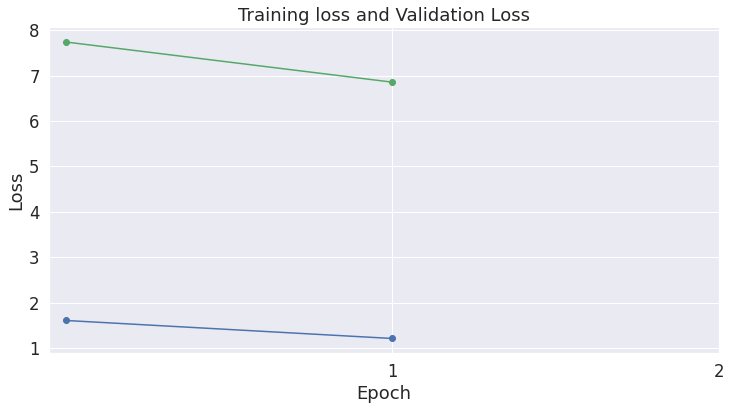

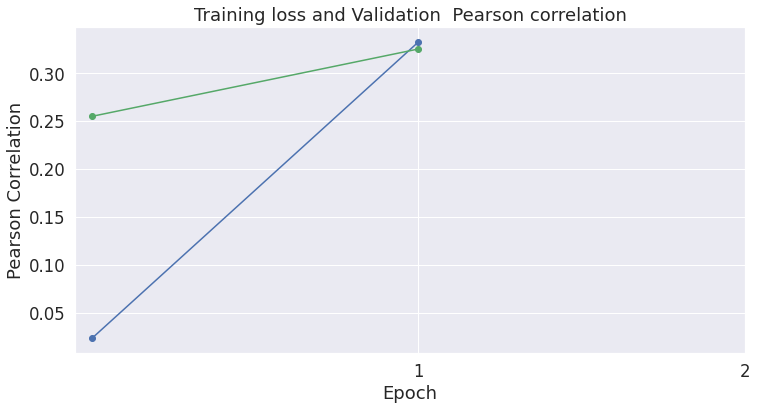

In [ ]:
helper.train(model=model_siamese)

In [ ]:
accuracy = helper.testing(model_siamese)
print(accuracy)

[INFO] step (1) Use defined funtion to extract tokenize data and get loaders
[INFO] step (2) Evaluate the model
0.24349624690256086
